# Neural Network

In [1]:
from keras.src.callbacks import early_stopping
from sklearn.metrics import (matthews_corrcoef, confusion_matrix,
                             classification_report, ConfusionMatrixDisplay)
from joblib import dump
from ucimlrepo import fetch_ucirepo
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential, regularizers, callbacks
from tensorflow.keras.layers import InputLayer, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import utils
import keras
import keras_tuner
from keras import layers, regularizers

covertype = fetch_ucirepo(id=31)

X = covertype.data.features
y = covertype.data.targets
y = y - 1  # make classes 0-7 instead of 1-8

### Clean, Balance, and Split Data

In [2]:
# preprocess data using utils.py
X_clean, y_clean = utils.clean_data(X, y)

X_trainA, X_test, y_trainA, y_test = utils.split_data(X_clean, y_clean)

# X_train, y_train = utils.normalize_data(X_train, y_train)
X_train, y_train = utils.naive_undersample_data(X_trainA, y_trainA)

# create a validation set
validation_ratio = 0.1

X_train, X_val, y_train, y_val = utils.split_data(X_train, y_train, validation_ratio)

## Create Model

### Keras Tuner

In [3]:
def build_keras_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(54,1)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(
                  hp.Choice('units', [16, 32, 64, 128, 256, 512, 1024]),
                  activation='relu',
                  kernel_regularizer=keras.regularizers.l2(0.01)
              ))
    model.add(keras.layers.Dense(
                  hp.Choice('units', [16, 32, 64, 128, 256, 512, 1024]),
                  activation='relu',
                  kernel_regularizer=keras.regularizers.l2(0.01)
              ))
    model.add(keras.layers.Dense(
                  hp.Choice('units', [16, 32, 64, 128, 256, 512, 1024]),
                  activation='relu',
                  kernel_regularizer=keras.regularizers.l2(0.01)
              ))
    model.add(keras.layers.Dense(7, activation='softmax'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
    )
    return model


In [4]:
build_keras_model(keras_tuner.HyperParameters())

C:\Users\Kills\miniconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


<Sequential name=sequential, built=True>

In [5]:
tuner = keras_tuner.GridSearch(
    hypermodel = build_keras_model,
    objective='val_loss',
    max_trials=100,
    overwrite=True,
)

#### Tune Keras Model

In [6]:
tuner.search(X_train, y_train, epochs=15, validation_data=(X_val, y_val))

Trial 1 Complete [00h 00m 16s]
val_loss: 1.4015361070632935

Best val_loss So Far: 1.4015361070632935
Total elapsed time: 00h 00m 16s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
32                |16                |units

Epoch 1/15


C:\Users\Kills\miniconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


433/433 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2255 - loss: 20.8894 - val_accuracy: 0.2632 - val_loss: 7.4411
Epoch 2/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2959 - loss: 6.0489 - val_accuracy: 0.2917 - val_loss: 4.6991
Epoch 3/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3416 - loss: 4.5824 - val_accuracy: 0.3925 - val_loss: 4.0492
Epoch 4/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3835 - loss: 3.5961 - val_accuracy: 0.3931 - val_loss: 3.8632
Epoch 5/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4047 - loss: 3.2083 - val_accuracy: 0.4146 - val_loss: 3.1070
Epoch 6/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4309 - loss: 2.9223 - val_accuracy: 0.3652 - val_loss: 3.0262
Epoch 7/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4511 - loss: 2.7110 - val_accuracy: 0.4561 - val_loss: 2.4545
Epoch 8/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4672 - loss: 2.5039 - val_accuracy: 0.5029 - val

KeyboardInterrupt: 

In [6]:
from joblib import dump, load
model = load('../data/best_neural_network2.joblib')

C:\Users\Aidan\Documents\pythonschool\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [5]:
model = tuner.get_best_models(num_models=3)[0]
tuner.search_space_summary()

NameError: name 'tuner' is not defined

### Manual Model

In [59]:
model = Sequential(
    [
        InputLayer(input_shape=(54,1)),
        Flatten(),
        Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dense(7, activation='softmax')
    ]
)

C:\Users\Kills\miniconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [61]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00025),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

### Train Best Model

In [46]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)             │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1024)           │        56,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,162,695 (8.25 MB)

 Trainable params: 2,162,695 (8.25 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# retrain on best parameters
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

fitted = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=400,
    batch_size=128,
    verbose=1,
    callbacks = [early_stopping]
)

Epoch 1/400
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.2798 - loss: 26.8048 - val_accuracy: 0.2684 - val_loss: 9.3037
Epoch 2/400
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.3649 - loss: 7.3190 - val_accuracy: 0.4009 - val_loss: 6.5458
Epoch 3/400
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.4279 - loss: 4.9184 - val_accuracy: 0.3886 - val_loss: 5.7046
Epoch 4/400
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.4551 - loss: 3.9200 - val_accuracy: 0.5068 - val_loss: 3.1623
Epoch 5/400
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.5099 - loss: 3.1708 - val_accuracy: 0.5530 - val_loss: 2.4835
Epoch 6/400
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5358 - loss: 2.8538 - val_accuracy: 0.5458 - val_loss: 2.8237
Epoch 7/400
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5294 - loss: 2.9466 - val_accuracy: 0.5673 - val_loss: 2.3564
Epoch 8/400
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5827 - loss: 2.4510 -

 ## Visualizations

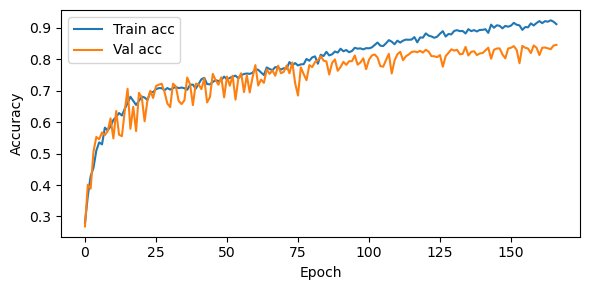

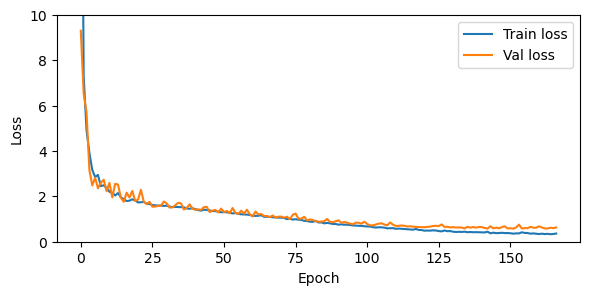

In [63]:
plt.figure(figsize=(6,3))
plt.plot(fitted.history["accuracy"], label="Train acc")
plt.plot(fitted.history["val_accuracy"], label="Val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
plt.plot(fitted.history["loss"], label="Train loss")
plt.plot(fitted.history["val_loss"], label="Val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.tight_layout()
axes = plt.gca()
axes.set_ylim([0, 10])
plt.show()

## Results

3632/3632 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
Test MCC: 0.5602241281884491

Confusion Matrix:
[[31103  6643    34     0   819    98  3671]
 [13576 34829  1918    33  4381  1384   540]
 [    7   104  5910   274    73   783     0]
 [    0     0    11   522     0    16     0]
 [   20    58    23     0  1787    11     0]
 [    5    62   340   154    28  2884     0]
 [  158    20     0     0     2     0  3922]]

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.73      0.71     42368
           1       0.83      0.61      0.71     56661
           2       0.72      0.83      0.77      7151
           3       0.53      0.95      0.68       549
           4       0.25      0.94      0.40      1899
           5       0.56      0.83      0.67      3473
           6       0.48      0.96      0.64      4102

    accuracy                           0.70    116203
   macro avg       0.58      0.84      0.65    116203
weighted avg       0.74   

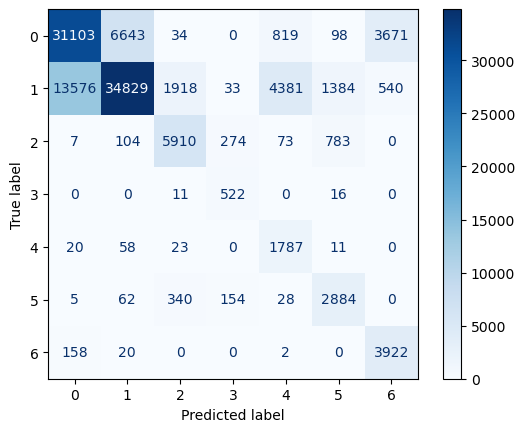

In [64]:
# See how our model does on the test set

# TODO: deal with softmax to a prediction and fix model rigidness.
# todo: categorize using sklearn on the y_true
y_predicted = model.predict(X_test)

# take argmax of y_predicted to find what it predicted
y_pred_idx = [np.argmax(row) for row in y_predicted]

test_mcc = matthews_corrcoef(y_test, y_pred_idx)
print("Test MCC:", test_mcc)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_idx))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_idx))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_idx, cmap="Blues")
plt.show()

In [65]:
# dump model
dump(model, "../data/best_neural_network7.joblib")

['../data/best_neural_network7.joblib']